# Lean, Mean, Stats Machine: Final Project

The following code details:
 * Data collection 
 * Exploration 
 * Model construction
 * Analysis of Text Sentiment 

Related to news articles across the last four years, since March 11, 2020, which is when COVID was declared an epidemic. 

Our focus will be on the difference between articles from two news outlets on opposing sides of the political spectrum, Fox and Vox. We pair text sentiment data with COVID statistics -- gathered from an external API -- to compare and contrast how different variables affect the sentiment between these two outlets.

### Importing Necessary Packages

In [1]:
# Webscraping Librarie
from bs4 import BeautifulSoup
from datetime import datetime
import requests
import time
from selenium import webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options

# Multi-threading for faster scraping
from multiprocessing import Pool
import concurrent.futures

# Data Manipulation Libraries
import math
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt

# Text Processing Libraries
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import string
import re
nltk.download('vader_lexicon')

# Other Libraries
import json
from urllib.request import urlopen

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\20gun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Webscraping - FOX News

First we define some basic variables. We are scraping FOX news content directly from an archive website, and use a convenient link format that includes a query with the year, and the page number of the resulting query. Each header that appears in each of these links is actually a set of articles, and not just one article.

Through manual inspection, we also define how many pages of news content each year has in this archive website. 

In [2]:
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT x.y; Win64; x64; rv:10.0) Gecko/20100101 Firefox/10.0'}

archive_url_2020 = 'https://archive.org/details/TV-FOXNEWSW?sort=-publicdate&and[]=year%3A"2020"&page='
archive_url_2021 = 'https://archive.org/details/TV-FOXNEWSW?sort=-publicdate&and[]=year%3A"2021"&page='
archive_url_2022 = 'https://archive.org/details/TV-FOXNEWSW?sort=-publicdate&and[]=year%3A"2022"&page='
archive_url_2023 = 'https://archive.org/details/TV-FOXNEWSW?sort=-publicdate&and[]=year%3A"2023"&page='


total_pages_2020 = 111
total_pages_2021 = 107
total_pages_2022 = 111
total_pages_2023 = 54

Given the base format of a url, for each year in our case, this function returns the entry point, i.e another web page, to access raw text content of FOX news articles. 

In [ ]:
def get_set_articles_urls(url_base_format,num_pages):
    set_articles_urls = []
    
    try:
        for page in tqdm(range(num_pages)):
            cur_url = url_base_format + str(page+1)

            cur_req = requests.get(cur_url,headers=headers)
            cur_soup = BeautifulSoup(cur_req.content,'lxml')

            article_entry_points = cur_soup.find_all('div',{'class':'item-ttl'})

            article_anchors = ['https://archive.org' + article_entry_points[i].find('a').get('href') for i in range(len(article_entry_points))]
            set_articles_urls.extend(article_anchors)
    except:
        print('Idk, something broke')
        
    return set_articles_urls

In [ ]:
article_sets_urls_2020 = get_set_articles_urls(archive_url_2020,total_pages_2020)
article_sets_urls_2021 = get_set_articles_urls(archive_url_2021,total_pages_2021)
article_sets_urls_2022 = get_set_articles_urls(archive_url_2022,total_pages_2022)
article_sets_urls_2023 = get_set_articles_urls(archive_url_2023,total_pages_2023)

Getting article dates so that now each piece of text can be paired with the date it was published. 

In [ ]:
def get_article_dates(article_urls):
    dates_unsplit = [''.join(article_urls[i].split('/')).split('_')[1] for i in range(len(article_urls))]
    split_dates = [(date[:4],date[4:6],date[-2:]) for date in dates_unsplit]
    
    return dict(zip(article_urls,split_dates))

Now that we have access to the intermediary web pages, we scrape those and return a dictionary where the keys are the article texts themselves, and the values are the date they were published. 

There are approximately 8000 of these intermediary pages with about 60 pieces of text each. This is simply too much data for our purposes, we instead select 2000 random sets of articles to parse. Even when taking this into account, we have about 400,000 pieces of text in the final table. 

In [ ]:
def get_article_contents(article_set_urls,num_rand_articles):
    
    article_date_dict = get_article_dates(article_set_urls)
    article_date_pairings = {}
    
    random_indices = np.random.randint(low=0,high=len(article_set_urls),size=num_rand_articles)
    rand_article_sets = np.array(article_set_urls)[random_indices]
        
    for article_set_url in tqdm(rand_article_sets):
    
        associated_date = article_date_dict[article_set_url]
        year, month,day = int(associated_date[0]),int(associated_date[1]), int(associated_date[2])
        
        #Looking at only data past March 11,2020 ()
        if (month < 3 and day < 11) and year == 2020:
            continue
        
        cur_article_req = requests.get(article_set_url,headers=headers)
        cur_article_soup = BeautifulSoup(cur_article_req.content,'lxml')
        
        article_snippets = cur_article_soup.find_all('div',{'class':'snipin nosel'})
        text_snippets = [snippet.text.replace('\n','').replace('\t','') for snippet in article_snippets]
        
        for snippet in text_snippets:
            article_date_pairings[snippet] = associated_date
    
    return article_date_pairings

Ran this code for each year. 

In [ ]:
article_date_pairings_2023 = get_article_contents(article_sets_urls_2023,num_rand_articles) 

In [ ]:
with open('Serialized Datasets/2023_articles.pkl','wb') as pickle_file:
    pickle.dump(article_date_pairings_2023,pickle_file)

### Webscraping - VOX
---
"Left" leaning news outlets were chosen based off of political lean ratings determined by [AllSides](https://www.allsides.com/about) which is a media solutions company which establishes a third-party review of the political affilation and perspectives which various media outlets display. They also provide community-based tools which help establish an agreement and validity scale of their results by permitting users to vote on whether or not they agree or disagree with the lean they deem on a website.

- [Vox Media](https://www.vox.com/) which declared bankruptcy recently lol.
    - AllSides gives it a score of -4 indicating that it is a solid Left lean.

In [ ]:
def get_vox_news(from_:str, to_:str):
    '''
    Performs webscraping of the archieve 

    Parameters
    ----------
    from_ (str): Start date of the search in the format YYYY-MM
    to_ (str):   End date of the search in the format YYYY-MM

    Returns
    -------
    dict: Dictionary containing news headlines, links, dates, and media source
    '''
    # Configure Selenium Webdriver
    chromeOptions = Options()
    chromeOptions.add_argument("--headless=new")
    driver = webdriver.Chrome(options=chromeOptions)

    # Utilize beautiful soup to scrape the Vox archive
    main_url = 'https://www.vox.com/archives'

    # Relevant fields for search
    optimized_feature = 'data-chorus-optimize-field'
    analytic_feature = 'data-analytics-link'

    # Generate list of relevant dates to search from the Vox archive
    dates = pd.date_range(from_, to_, freq='MS').strftime("%Y/%#m").tolist()

    # Search through the archive within dates
    all_headlines = {}
    with tqdm(total=len(dates)) as pbar:
        for date in dates:
            dated_url = f'{main_url}/{date}'
            driver.get(dated_url)

            # Continue to press the "Load More" button while it is clickable
            while True:
                try:
                    # Wait for "Load More" button to be clickable
                    load_more = WebDriverWait(driver, 10, 8).until(
                        EC.element_to_be_clickable((By.CLASS_NAME, 'c-archives-load-more__button')
                    )) # Little reminder that CLASS_NAME can only be singular, no spaces
                    load_more.click()
                except:
                    break
            
            # Create a BeautifulSoup object
            soup = bs(driver.page_source, 'html.parser')

            # Find all the <a> tags
            headlines = soup.find_all('a', {optimized_feature: 'hed', analytic_feature: True})
            times     = soup.find_all('time', {'class': 'c-byline__item', 'data-ui': 'timestamp'})

            # Add headlines to dictionary as key and links and date as values
            for headline, time in zip(headlines, times):
                all_headlines[headline.text] = {
                    "link": headline['href'],
                    "date": time['datetime'][:10],
                    "source": "Vox"
                }
            
            # Update the progress bar
            pbar.update()
    driver.quit()
    return all_headlines

In [ ]:
vox_results = get_vox_news('2019-03', '2023-05')

In [ ]:
vox_df = pd.DataFrame.from_dict(vox_results, orient='index')
# Sort the data by date
vox_df.sort_values(by='date', inplace=True)

In [ ]:
def get_content(link: str) -> str:
    '''
    Gathers the content of the article from the link

    Parameters
    ----------
    link (str): Link to the article

    Returns
    -------
    str: Content of the article
    '''
    # Uses simple requests to get the content of the article
    totalTime = 0
    response = requests.get(link)
    soup = BeautifulSoup(response.content, 'html.parser')
    content = soup.find_all('p')
    # Wait and retry if the content is empty
    while (len(content) == 0) and (totalTime < 300):
        time.sleep(30)
        totalTime += 30
        response = requests.get(link)
        soup = BeautifulSoup(response.content, 'html.parser')
        content = soup.find_all('p')
    # Remove the last 7 paragraphs which is not part of the article
    content = content[:-7]
    print(link)
    return '\n'.join([c.text for c in content])

In [ ]:
def process_links(links: list) -> list:
    '''
    Processes the links in parallel using multithreading

    Parameters
    ----------
    df (pd.DataFrame): Dataframe containing the links

    Returns
    -------
    list: List of article contents
    '''
    # Create a pool of workers to execute processes
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # Execute the processes and return the results
        futures = [executor.submit(get_content, link) for link in links]

        # Wait for the processes to finish and return the results
        results = [future.result() for future in concurrent.futures.as_completed(futures)]

    return results

### Creating Tables from Scraped Data - FOX

In [3]:
article_date_pairings_2020 = pickle.load(open('Serialized Datasets/2020_articles.pkl','rb'))
article_date_pairings_2021 = pickle.load(open('Serialized Datasets/2021_articles.pkl','rb'))
article_date_pairings_2022 = pickle.load(open('Serialized Datasets/2022_articles.pkl','rb'))
article_date_pairings_2023 = pickle.load(open('Serialized Datasets/2023_articles.pkl','rb'))

Creating a more convenient format to parse the data across the four years

In [4]:

combined_dict = {
    '2020':article_date_pairings_2020,
    '2021':article_date_pairings_2021,
    '2022':article_date_pairings_2022,
    '2023':article_date_pairings_2023
}

all_articles = []
all_dates = []

for year in combined_dict.keys():
    current_articles,current_dates = combined_dict[year].keys(), combined_dict[year].values()
                                                                                    
    all_articles.extend(current_articles),all_dates.extend(current_dates)

Re-formatting dates so they are no longer ordered triples

In [5]:
years = [all_dates[i][0]  for i in range(len(all_dates))]
months = [all_dates[i][1]  for i in range(len(all_dates))]
days = [all_dates[i][2]  for i in range(len(all_dates))]

reformatted_dates = [f'{years[i]}-{months[i]}-{days[i]}' for i in range(len(years))]

In [6]:
full_table_fox = pd.DataFrame({
    'Article Text':all_articles,
    'Year':years,
    'Month':months,
    'Day':days,
    'Full Date':reformatted_dates
})

full_table_fox

,Article Text,Year,Month,Day,Full Date
0,at -- actually 49 days and 2 hours...,2020,09,15,2020-09-15
1,popular vote. >> his selection is ...,2020,09,15,2020-09-15
2,>> you know the old saying no news...,2020,09,15,2020-09-15
3,all age groups. the hospitalizatio...,2020,09,15,2020-09-15
4,and dr. fauci didn't elaborate on ...,2020,09,15,2020-09-15
...,...,...,...,...,...
398656,>> that's right. whoever has the c...,2023,05,26,2023-05-26
398657,it's really bad for you but i feel...,2023,05,26,2023-05-26
398658,>> i think we cracked the case. >>...,2023,05,26,2023-05-26
398659,scratcher eyeball. >> i'm going to...,2023,05,26,2023-05-26


Our pre-processing function for the raw text before we calculate a sentiment score for each piece.

In [6]:
pattern = re.compile(r'[^A-Za-z0-9 ]+')
stopword_set = set([word.lower() for word in stopwords.words('english')])
stemmer = SnowballStemmer('english')

def preprocess_article(article: str) -> str:
    '''
    Preprocess the article content by removing punctuation, numbers, and stopwords and tokenizing the words

    Parameters
    ----------
    article: str

    Returns
    -------
    None
    '''
    article = article.lower()
    article = article.translate(str.maketrans('', '', string.punctuation))
    article = pattern.sub('', article)
    
    content = nltk.word_tokenize(article)
    content = [stemmer.stem(word) for word in content if word.lower() not in stopword_set]

    final = ' '.join(content)
    return final

In [9]:
tqdm.pandas(desc='Applying text-pre processing')

processed_text = full_table_fox['Article Text'].progress_apply(preprocess_article)

Applying text-pre processing:   0%|          | 0/398661 [00:00<?, ?it/s]

In [10]:
full_table_fox['Article Text'] = processed_text

### Creating Tables from Scraped Data - Vox

In [ ]:
# Split the dataframe into 4 parts for each of the 4 years
vox_2020 = vox_df[vox_df['date'].str.contains('2020')]
vox_2021 = vox_df[vox_df['date'].str.contains('2021')]
vox_2022 = vox_df[vox_df['date'].str.contains('2022')]
vox_2023 = vox_df[vox_df['date'].str.contains('2023')]

# Put each of these dataframes into a list
vox_dfs = [vox_2020, vox_2021, vox_2022, vox_2023]

In [ ]:
# Process the links of each year with multithreading
# Add confirmations to prevent accidental execution
for i, df in enumerate(vox_dfs):
    print(f'Processing {i+1} of 4')
    confirmation = input('Continue? (y/n): ')
    if confirmation == 'y':
        # Get the content of the articles
        df['content'] = process_links(df['link'].tolist())
        # Export the dataframe to a csv file
        df.to_csv(f'vox_{i+1}.csv', encoding='utf-8-sig', chunksize=None)
    else:
        print('Skipping...')

Doing some data validation and cleaning.

In [2]:
# load in the full dataset
vox_df_full = pd.read_csv('vox_df_full_backup.csv', index_col=0)

In [3]:
# Parse out the date from each of the articles and then add them in by year, month, and day
vox_df_full['date'] = pd.to_datetime(vox_df_full['date'])

vox_df_full['Year'] = vox_df_full['date'].apply(lambda x: x.year)
vox_df_full['Month'] = vox_df_full['date'].apply(lambda x: x.month)
vox_df_full['Day'] = vox_df_full['date'].apply(lambda x: x.day)

In [4]:
# Add the index as a new column called headline
vox_df_full['headline'] = vox_df_full.index

# Reindex the dataframe to just use numbers
vox_df_full.reset_index(drop=True, inplace=True)

# Drop the link column
vox_df_full.drop('link', axis=1, inplace=True)

# Reorder the columns to headline, source, content, date, year, month, day
vox_df_full = vox_df_full[['headline', 'source', 'content', 'year', 'month', 'day', 'date']]

# Rename the columns to match the other dataframes
vox_df_full.rename(columns={'content':'Article Text'}, inplace=True)

# Drop the rows that have no content
vox_df_full.dropna(inplace=True)

In [7]:
# Run the preprocessing on the article content
tqdm.pandas(desc='Applying text-pre processing')

processed_text = vox_df_full['Article Text'].progress_apply(preprocess_article)

Applying text-pre processing:   0%|          | 0/20135 [00:00<?, ?it/s]

In [8]:
# Apply the processed text to the dataframe
vox_df_full['Article Text'] = processed_text

# Calculating Sentiment

To calculate sentimen of a piece of text we will use the VADER Sentiment Analyzer, which is convenient for regression problems, as it outputs both the sentiment and its associated strength in a certain direction. 

In [24]:
sia = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment_scores = sia.polarity_scores(text)
    sentiment = sentiment_scores['compound']
    
    return sentiment

In [ ]:
tqdm.pandas(desc='Calculating Polarity Scores')
polarity_scores = full_table_fox['Article Text'].progress_apply(analyze_sentiment)

In [14]:
full_table_fox['Polarity Score'] = polarity_scores

In [16]:
full_table_fox.to_csv('full_table_fox.csv')

In [26]:
# Apply the sentiment analysis to the vox dataframe
tqdm.pandas(desc='Calculating Polarity Scores')
polarity_scores = vox_df_full['Article Text'].progress_apply(analyze_sentiment)

Calculating Polarity Scores:   0%|          | 0/20135 [00:00<?, ?it/s]

In [27]:
vox_df_full['Polarity Score'] = polarity_scores

In [29]:
# Save to a csv file
vox_df_full.to_csv('vox_df_complete.csv', encoding='utf-8-sig', chunksize=None)

### Getting COVID statistics to merge with Sentiment Data
---
The following portion of our code will overview how we collected the COVID data and merged  it with the tables about sentiment.

In [2]:
full_table_fox = pd.read_csv('full_table_fox.csv')

In [3]:
api_key = '3683057711b142c8a7508f588006e6be'
request_link = 'https://api.covidactnow.org/v2/country/US.timeseries.json?apiKey=' + api_key

response = urlopen(request_link).read()
response_json = json.loads(response.decode('utf-8','strict'))

In [4]:
time_series_json = response_json['metricsTimeseries']

keys = time_series_json[0].keys()
data = [[] for _ in keys]

time_series_dict = dict(zip(keys,data))

for entry in time_series_json:
    for key in entry:
        try:
            time_series_dict[key].append(entry[key])
            
        #Some ragged entries - keys only for some special areas of time like Fall 2022 Booster Received Rate
        except KeyError:
            continue

In [5]:
covid_data_table = pd.DataFrame(time_series_dict)
covid_data_table

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,contactTracerCapacityRatio,infectionRate,infectionRateCI90,icuCapacityRatio,bedsWithCovidPatientsRatio,weeklyCovidAdmissionsPer100k,date
0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-09
1,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-10
2,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-11
3,NaN,0.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-12
4,NaN,0.1,0.4,NaN,1.83,0.83,NaN,NaN,NaN,2020-03-13
...,...,...,...,...,...,...,...,...,...,...
1186,NaN,NaN,NaN,NaN,NaN,NaN,0.73,0.014,2.2,2023-06-08
1187,NaN,NaN,NaN,NaN,NaN,NaN,0.73,0.014,2.1,2023-06-09
1188,NaN,NaN,NaN,NaN,NaN,NaN,0.72,0.014,2.1,2023-06-10
1189,NaN,NaN,NaN,NaN,NaN,NaN,0.71,0.013,2.1,2023-06-11


A lot of these columns have missing values. Let's see for which column what percentage of that column has missing values to see if it is even worth using in subsequent regression. 

In [6]:
columns = covid_data_table.columns.values
missing_values_proportion_dict = {}

for column in columns:
    cur_column = covid_data_table[column].values
    try:
        proportion_missing = np.sum(np.isnan(cur_column))/len(cur_column)
    
    #A mix of NaN and none values stored, so if using isnan this breaks, have to check if it is None
    except TypeError:
        proportion_missing = np.sum(cur_column == None) / len(cur_column)
    
    missing_values_proportion_dict[column] = proportion_missing
    
missing_values_proportion_dict

{'testPositivityRatio': 0.03610411418975651,
 'caseDensity': 0.06381192275398824,
 'weeklyNewCasesPer100k': 0.06381192275398824,
 'contactTracerCapacityRatio': 0.5113350125944585,
 'infectionRate': 0.031066330814441646,
 'infectionRateCI90': 0.031066330814441646,
 'icuCapacityRatio': 0.1847187237615449,
 'bedsWithCovidPatientsRatio': 0.1847187237615449,
 'weeklyCovidAdmissionsPer100k': 0.1897565071368598,
 'date': 0.0}

In [7]:
covid_data_table

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,contactTracerCapacityRatio,infectionRate,infectionRateCI90,icuCapacityRatio,bedsWithCovidPatientsRatio,weeklyCovidAdmissionsPer100k,date
0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-09
1,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-10
2,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-11
3,NaN,0.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-12
4,NaN,0.1,0.4,NaN,1.83,0.83,NaN,NaN,NaN,2020-03-13
...,...,...,...,...,...,...,...,...,...,...
1186,NaN,NaN,NaN,NaN,NaN,NaN,0.73,0.014,2.2,2023-06-08
1187,NaN,NaN,NaN,NaN,NaN,NaN,0.73,0.014,2.1,2023-06-09
1188,NaN,NaN,NaN,NaN,NaN,NaN,0.72,0.014,2.1,2023-06-10
1189,NaN,NaN,NaN,NaN,NaN,NaN,0.71,0.013,2.1,2023-06-11


Based on the above output of the dictionary, we will drop four columns, as shown below. We will also drop rows with nan values, instead of just replacing them with zeroes as this can seriously affect regression results. 

In [8]:
covid_data_table = covid_data_table.drop(columns = ['contactTracerCapacityRatio',
                                                    'icuCapacityRatio',
                                                    'bedsWithCovidPatientsRatio',
                                                    'weeklyCovidAdmissionsPer100k'])

In [9]:
covid_data_table = covid_data_table.dropna()
covid_data_table = covid_data_table.reset_index().drop(columns='index')

We now working on merging the two tables across date by first summarzing the sentiment related data table by grouping by the specific date, since every entry in the covid data table has a granularity of day to day. (i.e we need the same number of entries in the tables for regression purposes). 

In [10]:
fox_table_grouped = full_table_fox.groupby('Full Date').mean()['Polarity Score']

Further, there are some conflicts in terms of dates present in the covid data table, and the dates available in the grouped sentiment data, since earlier we dropped rows with faulty values in the covid data table. We resolve these issues below and create the final table. 

In [11]:
available_dates = covid_data_table['date'].values
fox_table_dates = fox_table_grouped.index.values
rows_to_drop = []

available_polarity_scores = []

#Only consider dates that are in our available set of dates after we dropped some rows in the covid data table
dates_to_ignore = set(available_dates).difference(set(fox_table_dates))

for row in covid_data_table.index:
    if covid_data_table.iloc[row].date in dates_to_ignore:
        rows_to_drop.append(row)

for i in range(len(fox_table_grouped.index)):
    cur_date = fox_table_grouped.index[i]
    if cur_date in available_dates:
        available_polarity_scores.append(fox_table_grouped[i])
        
for row in rows_to_drop:
    covid_data_table = covid_data_table.drop(row)

len(available_polarity_scores),len(covid_data_table['date'].values)

(1099, 1099)

In [12]:
covid_data_table['Polarity Scores'] = available_polarity_scores

In [13]:
covid_data_table

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,infectionRateCI90,date,Polarity Scores
0,0.128,0.1,0.6,1.83,0.12,2020-03-14,0.427703
1,0.124,0.1,0.7,1.83,0.10,2020-03-15,0.450716
2,0.131,0.1,1.0,1.82,0.10,2020-03-16,0.321825
3,0.129,0.2,1.4,1.81,0.10,2020-03-17,0.449744
4,0.127,0.4,2.8,1.79,0.10,2020-03-19,0.410640
...,...,...,...,...,...,...,...
1101,0.050,3.6,25.0,1.09,0.10,2023-05-05,0.270646
1102,0.050,3.5,24.5,1.11,0.10,2023-05-06,0.397678
1103,0.050,3.4,24.1,1.13,0.10,2023-05-07,0.148437
1104,0.049,3.4,23.7,1.15,0.10,2023-05-08,0.188102


A quick sanity check below to make sure that the polarity scores in our new merged table match their values at each original data from the original table. 

In [14]:
proportion_matching = 0

for i in range(len(covid_data_table.index)):
    
    cur_date = covid_data_table.iloc[i].values[-2]
    cur_ps = covid_data_table.iloc[i].values[-1]
    
    compared_ps = fox_table_grouped[cur_date]
    
    proportion_matching += cur_ps == compared_ps
    
proportion_matching/len(covid_data_table.index)

1.0

### Merging Vox with COVID Data

In [ ]:
# Consolidate the sentiment scores by date for Vox
vox_grouped = vox_df_full.loc[:, 'Full Date':'Polarity Score'].groupby('Full Date').mean()['Polarity Score']

In [80]:
# Resolve the dates that are missing from the various frames
available_dates = covid_data_table['date'].values
vox_grouped_dates = vox_grouped.index.values
rows_to_drop = []

# Create a list of available polarity scores
available_polarity_scores = []

# Consider only date available in both sets after dropping some rows in the covid data table
dates_to_ignore = set(available_dates).difference(set(vox_grouped_dates))

# Drop the dates_to_ignore
for row in covid_data_table.index:
    if covid_data_table.iloc[row].date in dates_to_ignore:
        rows_to_drop.append(row)

# Add the polarity scores to the list
for i in range(len(vox_grouped.index)):
    cur_date = vox_grouped.index[i]
    if cur_date in available_dates:
        available_polarity_scores.append(vox_grouped[i])

# Drop the rows that are not in the available dates
for row in rows_to_drop:
    covid_data_table = covid_data_table.drop(row)

# See the length of the available polarity scores and the dates
len(available_polarity_scores),len(covid_data_table['date'].values)

(1101, 1101)

In [81]:
# Add the polarity scores to the covid data table
covid_data_table['Polarity Scores'] = available_polarity_scores

In [82]:
covid_data_table

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,infectionRateCI90,date,Polarity Scores
0,0.128,0.1,0.6,1.83,0.12,2020-03-14,0.691635
1,0.124,0.1,0.7,1.83,0.10,2020-03-15,0.572614
2,0.131,0.1,1.0,1.82,0.10,2020-03-16,0.733576
3,0.129,0.2,1.4,1.81,0.10,2020-03-17,0.688541
4,0.127,0.4,2.8,1.79,0.10,2020-03-19,0.724737
...,...,...,...,...,...,...,...
1101,0.050,3.6,25.0,1.09,0.10,2023-05-05,0.090867
1102,0.050,3.5,24.5,1.11,0.10,2023-05-06,0.940400
1103,0.050,3.4,24.1,1.13,0.10,2023-05-07,-0.004150
1104,0.049,3.4,23.7,1.15,0.10,2023-05-08,0.142443


Perform a sanity check to ensure that polarity scores in the new merged table match their values within the orignal data from the original Vox Grouped Table.

In [83]:
# Sanity Check
proportion_matching = 0

for i in range(len(covid_data_table.index)):
        
        cur_date = covid_data_table.iloc[i].values[-2]
        cur_ps = covid_data_table.iloc[i].values[-1]
        
        compared_ps = vox_grouped[cur_date]
        
        proportion_matching += cur_ps == compared_ps

proportion_matching/len(covid_data_table.index)

1.0

### Visualizations and EDA - FOX News

First, some basic trends we can visualize for each predictor

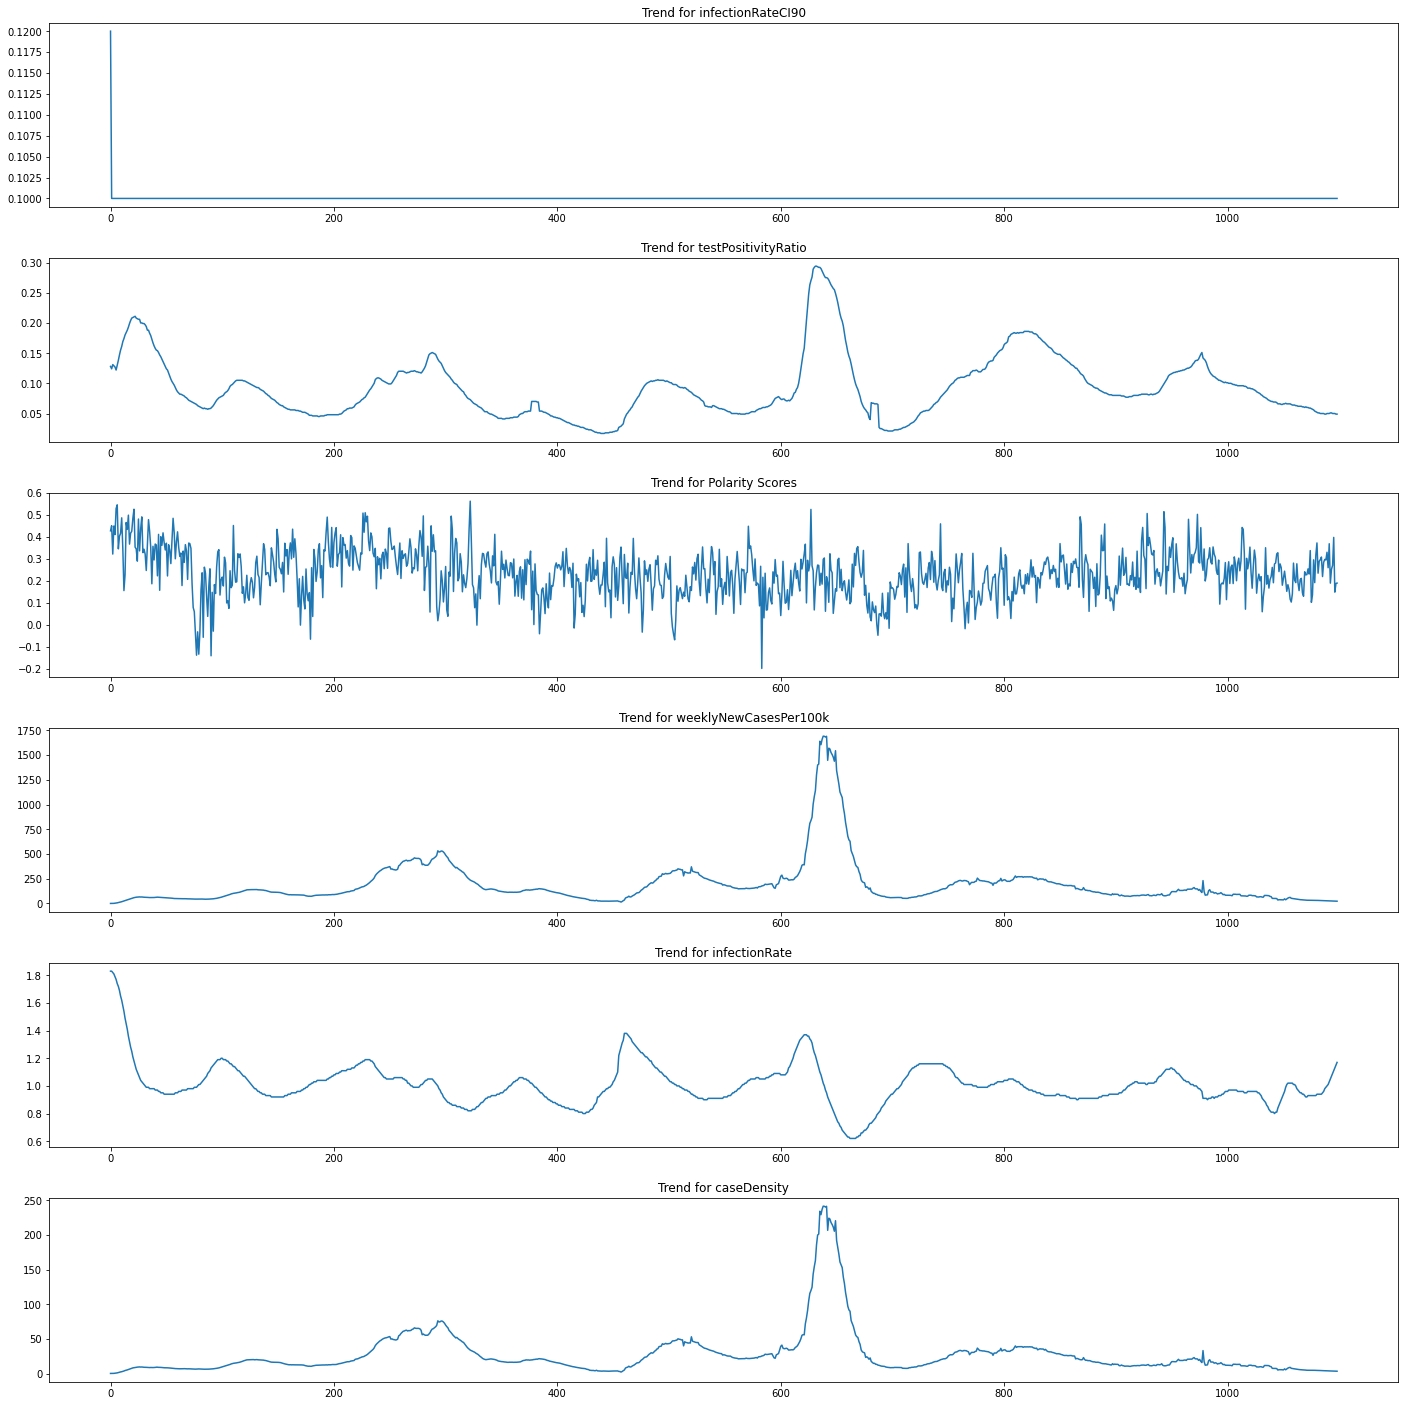

In [16]:
columns = list(set(covid_data_table.columns).difference({'date','index'}))
fig,ax = plt.subplots(len(columns),figsize=(20,20))
fig.tight_layout(pad=3.0)


for i in range(len(columns)):
    cur_column = columns[i]
    ax[i].plot(covid_data_table[cur_column].values)
    ax[i].set_title(f'Trend for {cur_column}')
    
plt.show()

Immediately, it seems that one of our predictors, infectionRateCI90, although has no missing values, it is not a very informative feature and may not have been properly recorded. We will drop this column.

In [17]:
covid_data_table = covid_data_table.drop(columns=['infectionRateCI90'])

Let's also see if there is any correlation between our predictors. 

In [18]:
covid_data_table.corr()

,testPositivityRatio,caseDensity,weeklyNewCasesPer100k,infectionRate,Polarity Scores
testPositivityRatio,1.000000,0.665256,0.665279,0.134815,0.145492
caseDensity,0.665256,1.000000,1.000000,-0.117906,-0.051615
weeklyNewCasesPer100k,0.665279,1.000000,1.000000,-0.117875,-0.051637
infectionRate,0.134815,-0.117906,-0.117875,1.000000,0.192342
Polarity Scores,0.145492,-0.051615,-0.051637,0.192342,1.000000


We seem to have a perfect positive correlation between caseDensity and weeklyNewCasesPer100k. We will rop he weeklyNewCasesPer100k column. 

In [19]:
covid_data_table = covid_data_table.drop(columns=['weeklyNewCasesPer100k'])

In [20]:
covid_data_table.corr()

,testPositivityRatio,caseDensity,infectionRate,Polarity Scores
testPositivityRatio,1.000000,0.665256,0.134815,0.145492
caseDensity,0.665256,1.000000,-0.117906,-0.051615
infectionRate,0.134815,-0.117906,1.000000,0.192342
Polarity Scores,0.145492,-0.051615,0.192342,1.000000


We additonally have some interaction between terms, especially betwen caseDensity and testPositivityRatio. We will consider these for interaction terms in our subsequent modeling section. For now, let's get a general understanding of the distribution of our data with a pair-plot. 

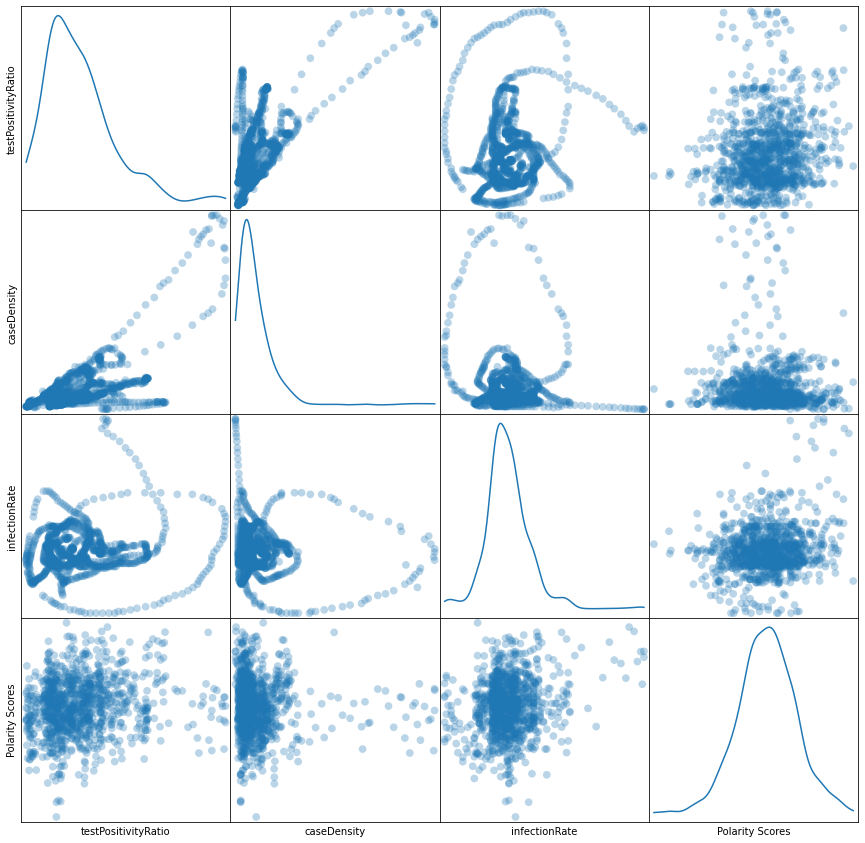

In [21]:
pair_plots = pd.plotting.scatter_matrix(covid_data_table,figsize=(15,15),marker='o', 
                                        hist_kwds={'bins': 20}, s=60, alpha=.3,diagonal='kde')

for subaxis in pair_plots:
    for ax in subaxis:
        ax.xaxis.set_ticks([]);
        ax.yaxis.set_ticks([]);
        
plt.xticks(fontsize=5);
plt.yticks(fontsize=5);

Something we notice is the roughly normal distribution of each of the predictors, and the respone variable, the Polarity Scores.

Observing the plots for caseDensity v.s testPositivityRatio as well reveals the roughly linear nature between the two groups, and suggests the usage of an interaction term between the two. 

Let's also take a look at the scatter plots between the response and the predictors to see if we can gain any more good information. 

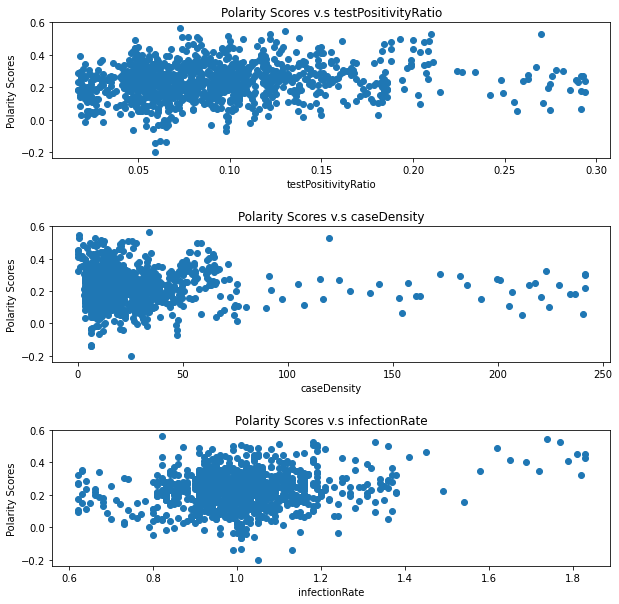

In [22]:
predictors = covid_data_table.columns[:-2]
response = covid_data_table['Polarity Scores']

fig, ax = plt.subplots(3,1,figsize=(10,10))

plt.subplots_adjust(hspace = 0.5)

for i in range(len(predictors)):
    
    cur_col = covid_data_table[predictors[i]]
    
    ax[i].scatter(cur_col,response)
    
    ax[i].set(xlabel=predictors[i],ylabel='Polarity Scores')
    ax[i].set_title(f'Polarity Scores v.s {predictors[i]}')

### Visualization and EDA  - VOX

Each trends will essentially be the same, except for Polarity as we will be reviewing that of Vox instead of Fox.

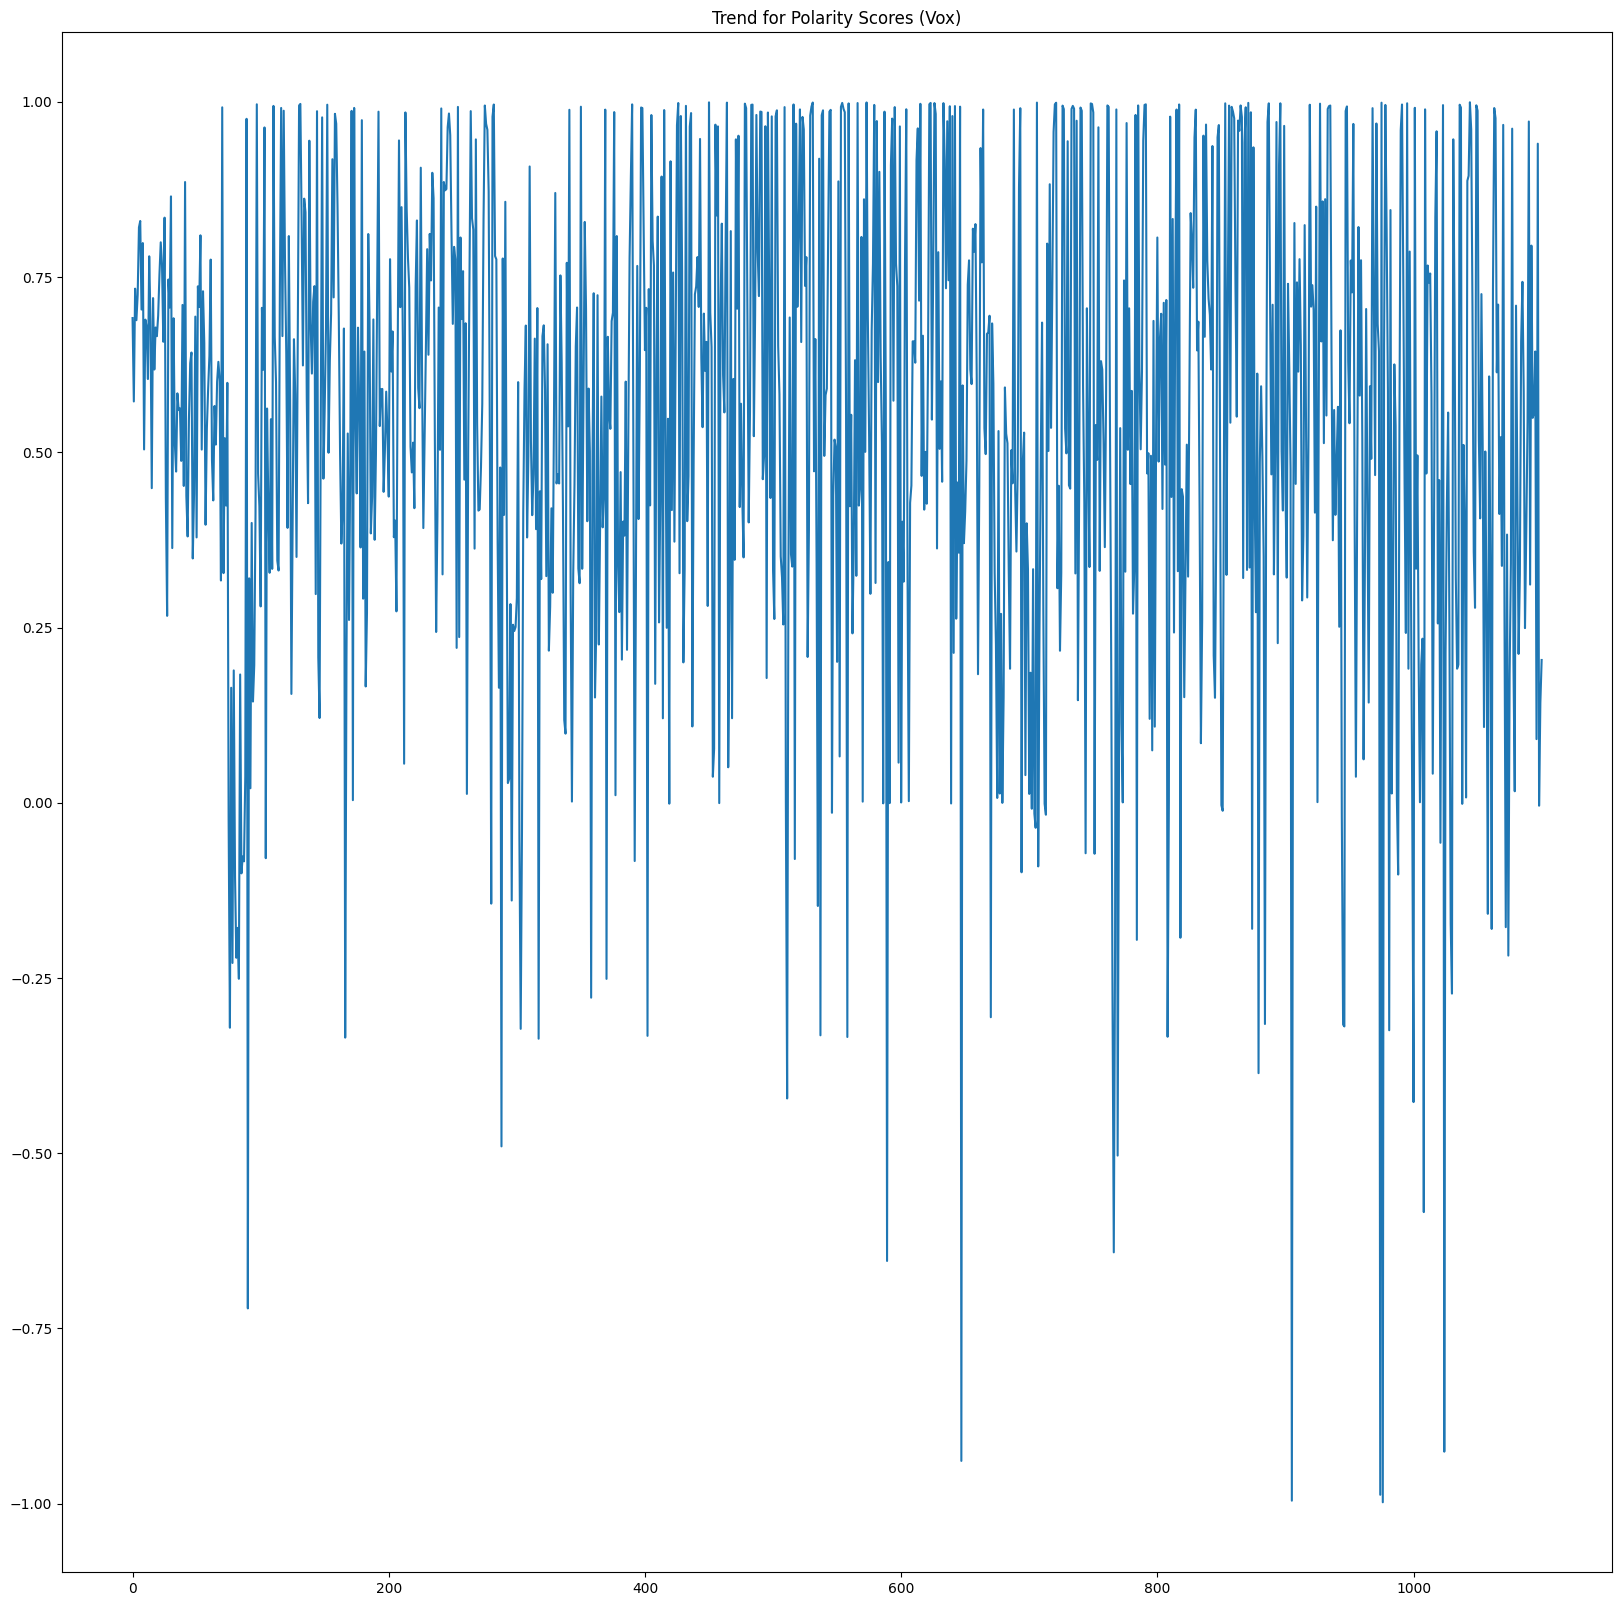

In [91]:
# Generate a list of our predictors
predictors = ['infectionRateCI90', 'Polarity Scores', 'infectionRate', 
              'weeklyNewCasesPer100k', 'caseDensity', 'testPositivityRatio']

# Plot some trends
fig, ax = plt.subplots(figsize=(20,20))

ax.plot(covid_data_table['Polarity Scores'].values)
ax.set_title('Trend for Polarity Scores (Vox)')

plt.show()

In [95]:
covid_data_table.drop(['date', 'infectionRateCI90', 'weeklyNewCasesPer100k'], axis=1, inplace=True)

In [96]:
# Search for correlations between predictors
covid_data_table.corr()

,testPositivityRatio,caseDensity,infectionRate,Polarity Scores
testPositivityRatio,1.000000,0.665125,0.135407,0.065260
caseDensity,0.665125,1.000000,-0.115721,0.049786
infectionRate,0.135407,-0.115721,1.000000,0.088575
Polarity Scores,0.065260,0.049786,0.088575,1.000000


We proceed similarly as before by generating some pair-plots.

(array([], dtype=float64), [])

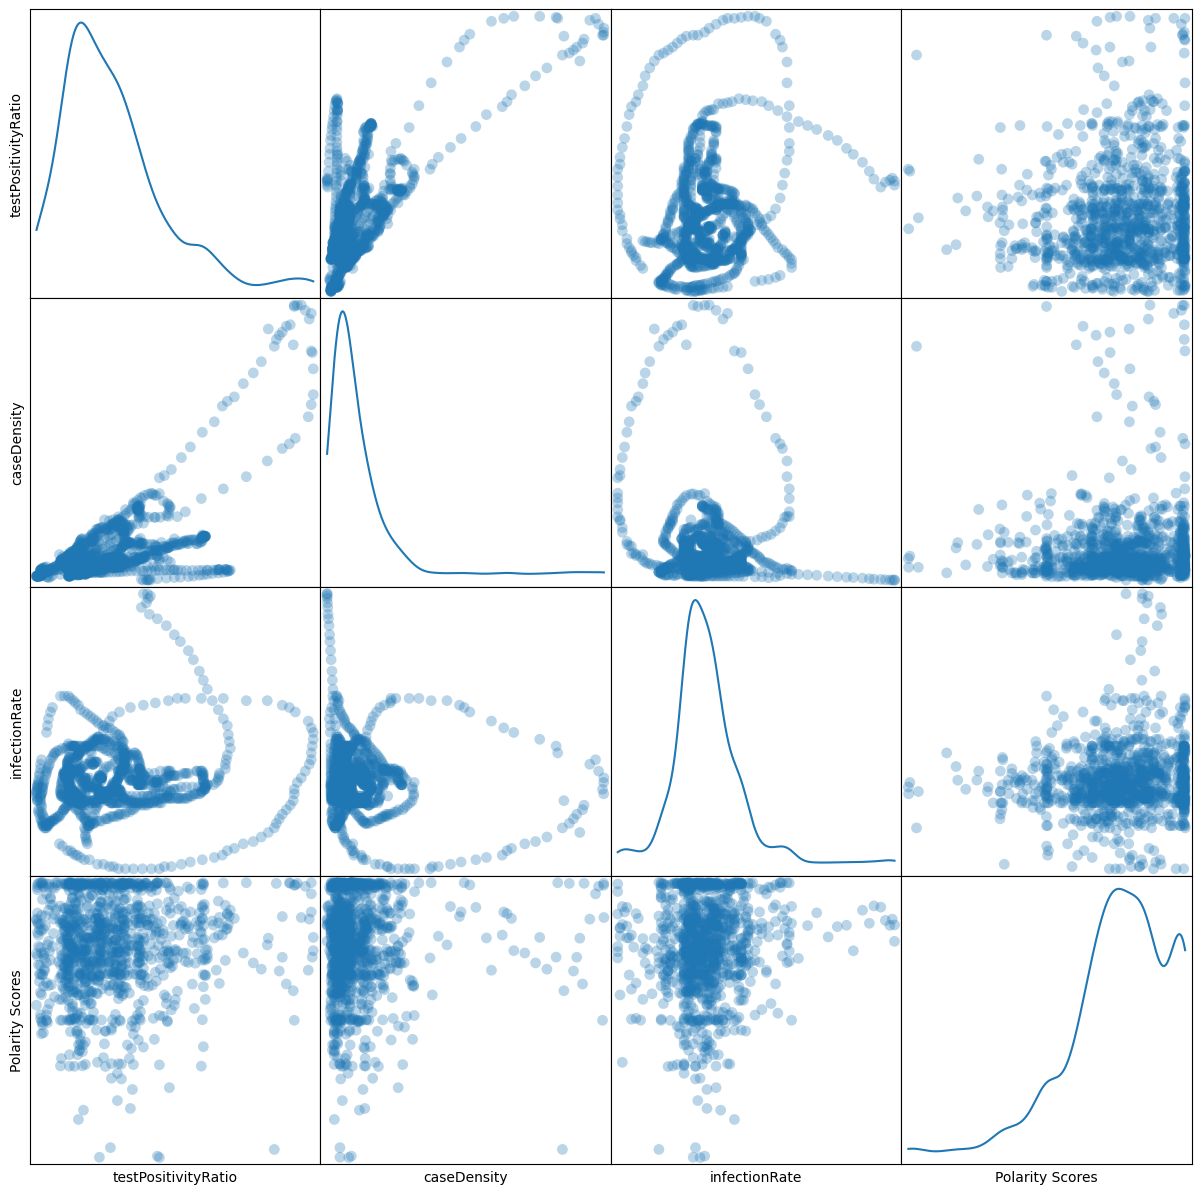

In [97]:
# Plot the pair plots
vox_pair_plots = pd.plotting.scatter_matrix(covid_data_table,figsize=(15,15),marker='o',
                                            hist_kwds={'bins': 20}, s=60, alpha=.3,diagonal='kde')

for subaxis in vox_pair_plots:
    for ax in subaxis:
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])

plt.xticks(fontsize=5)
plt.yticks(fontsize=5)

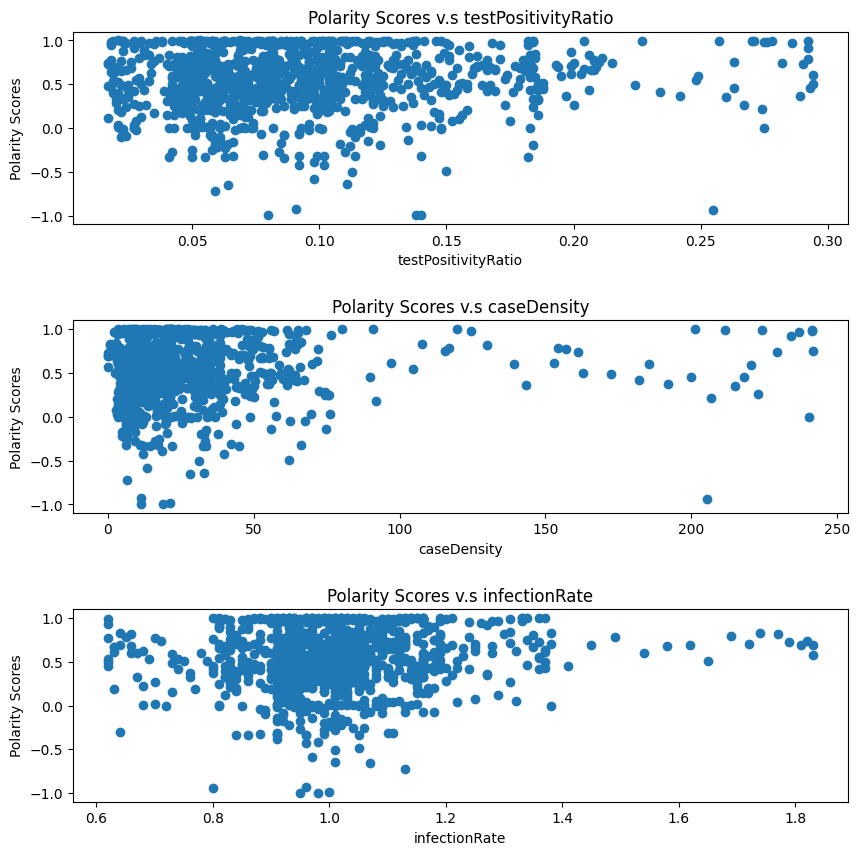

In [100]:
# Visualize a quick scatterplot to see the geenral relationship of response and predictors

fig, ax = plt.subplots(3,1,figsize=(10,10))

plt.subplots_adjust(hspace = 0.5)

vox_predictors = covid_data_table.columns[:-1]
response = covid_data_table['Polarity Scores']

for i in range(len(vox_predictors)):
    
    cur_col = covid_data_table[vox_predictors[i]]
    
    ax[i].scatter(cur_col,response)
    
    ax[i].set(xlabel=vox_predictors[i],ylabel='Polarity Scores')
    ax[i].set_title(f'Polarity Scores v.s {vox_predictors[i]}')

### Regression - FOX

Before we do any further processing of data, we split our data into a train and testing set. 85% of our data will go towards a training set, and the remaining 15% will make up our testing data. We will also remove the date column to ensure we only have numeric columns. 

In [23]:
covid_data_table = covid_data_table.drop(columns = ['date'])

In [24]:
val_split = 0.85
val_split_idx = int(len(covid_data_table) * 0.85)

training_data = covid_data_table.iloc[:val_split_idx]
testing_data = covid_data_table.iloc[val_split_idx:]

As we mentioned earlier, there was approximately a correlation of 0.66 between the caseDensity variable and the testPositivityRatio variable, thus we will create an interaction term from them.

In [25]:
#CD = case density
#TPR = Test Positivity Ratio

CD_TPR_interaction_training = training_data['caseDensity'].multiply(training_data['testPositivityRatio']) 
training_data['CD_TPR_int'] = CD_TPR_interaction_training

CD_TPR_interaction_testing = testing_data['caseDensity'].multiply(testing_data['testPositivityRatio']) 
testing_data['CD_TPR_int'] = CD_TPR_interaction_testing

c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Next, we normalize our predictors for the training and testing data using the Z-Transform.  

In [26]:
z_transform = lambda column,table:(table[column] - table[column].mean())/table[column].std()

predictors = set(training_data.columns).difference({'Polarity Scores'})

normalized_training_cols = [z_transform(col,training_data) for col in predictors]
normalized_testing_cols = [z_transform(col,testing_data) for col in predictors]

In [27]:
for i,col in enumerate(predictors):
    training_data[col] = normalized_training_cols[i]
    testing_data[col] = normalized_testing_cols[i]

c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\20gun\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We are now ready to perform a basic regression. Before doing any feature selection, we will first use all of our variables to get a good baseline approach. 

In [127]:
from statsmodels.formula.api import ols

In [29]:
training_data = training_data.rename(columns = {'Polarity Scores':'PolarityScores'})

In [30]:
base_model = ols(formula = 'PolarityScores ~ 1 + testPositivityRatio + caseDensity + infectionRate + CD_TPR_int',
                data = training_data
                ).fit()

In [31]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         PolarityScores   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     19.42
Date:                Tue, 13 Jun 2023   Prob (F-statistic):           2.33e-15
Time:                        18:28:39   Log-Likelihood:                 751.95
No. Observations:                 934   AIC:                            -1494.
Df Residuals:                     929   BIC:                            -1470.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.2306      0.004     64.976      0.000       0.224       0.238
testPositivityRatio     0.0300      0.005      5.781      0.000       0.020       0.040
caseDensity            -0.0057      0.013     -0.430      0.667      -0.032       0.020
infectionRate           0.0177      0.004      4.576      0.000       0.010       0.025
CD_TPR_int             -0.0177      0.013     -1.310      0.191      -0.044       0.009
==============================================================================
Omnibus:                        7.239   Durbin-Watson:                   1.014
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.516
Skew:                          -0.166   Prob(JB):                       0.0233
Kurtosis:                       3.288   Cond. No.                         8.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Our statistically significant predictors are the test positivity ratio, and infection rate. While case density and the interaction term betweencase density and the test positivity ratio has a p-value of 0.191, and the case density predictor has a p-value of 0.192.

Let us evaluate these models. To make sure that the error metric we use is on the same scale of the polarity scores, since it is especially important here given their meaning, and the fact that they are between -1 and 1 we will use the RMSE. However, this (-1,1) range was changed a little bit as we dropped some rows, so we will also report the mean absolute percentage error (MAPE).

In [37]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [34]:
def calculate_test_error(model, test_data,ground_truth_labels):
    y_hat = model.predict(test_data)
    rmse = np.sqrt(mean_squared_error(ground_truth_labels,y_hat))
    mape = mean_absolute_percentage_error(ground_truth_labels,y_hat)
    
    return rmse,mape
    

In [35]:
testing_data_features = testing_data.drop(columns = 'Polarity Scores')
ground_truth_labels = testing_data['Polarity Scores']

In [38]:
rmse, mape = calculate_test_error(base_model,testing_data_features,ground_truth_labels)
rmse,mape

(0.0843729105775739, 0.3005519074528697)

Now that we have some basic functionality, lets do some variable selection to get the best possible model. Since we only have four features, it realistic to perform best subset collection here. 

In [39]:
from itertools import combinations

In [40]:
all_combinations = []
[all_combinations.extend(combinations(predictors,i)) for i in range(len(predictors)+1)];

In [73]:
error_metric_dict = {
    'rmse': {},
    'mape': {}
}

In [91]:
for i,combination in enumerate(all_combinations):
    
    cur_formula = 'PolarityScores ~ 1 + ' + ' + '.join(combination)
    
    if i == 0:
        cur_formula = 'PolarityScores ~ 1'
                
    #predictors list contains all the possible predictors
    cols_to_drop = list(predictors.difference(set(combination)))
    
    cur_training_df = training_data.drop(columns = cols_to_drop)
    cur_testing_df = testing_data.drop(columns = cols_to_drop)
    
    cur_model = ols(formula = cur_formula,data = cur_training_df).fit()
    
    cur_rmse,cur_mape = calculate_test_error(cur_model,cur_testing_df,ground_truth_labels)
    
    error_metric_dict['rmse'][i] = cur_rmse
    error_metric_dict['mape'][i] = cur_mape

In [92]:
error_metric_dict['mape']

{0: 0.2914930954437342,
 1: 0.29471996179413734,
 2: 0.28357799943924555,
 3: 0.3082640611250337,
 4: 0.2958245129899102,
 5: 0.28968118369848,
 6: 0.3089124016260768,
 7: 0.29225038001178133,
 8: 0.3021792380245415,
 9: 0.2859971195829618,
 10: 0.30850092776536775,
 11: 0.3018167871807477,
 12: 0.28672762029779,
 13: 0.30899701293208093,
 14: 0.2970392794635871,
 15: 0.30055190745286975}

In [97]:
min_mape_arg = all_combinations[np.argmin(list(error_metric_dict['mape'].values()))]
min_rmse_arg = all_combinations[np.argmin(list(error_metric_dict['rmse'].values()))]

min_mape_arg

('testPositivityRatio',)

In [98]:
min_rmse_arg

('testPositivityRatio',)

In [185]:
formula = 'PolarityScores ~ 1 + testPositivityRatio'
training_df = training_data.drop(columns = ['caseDensity','infectionRate','CD_TPR_int'])

best_model = ols(formula = formula, data = training_df).fit()

testing_df = testing_data.drop(columns=['caseDensity','infectionRate','CD_TPR_int'])
best_predictions = best_model.predict(testing_df) 

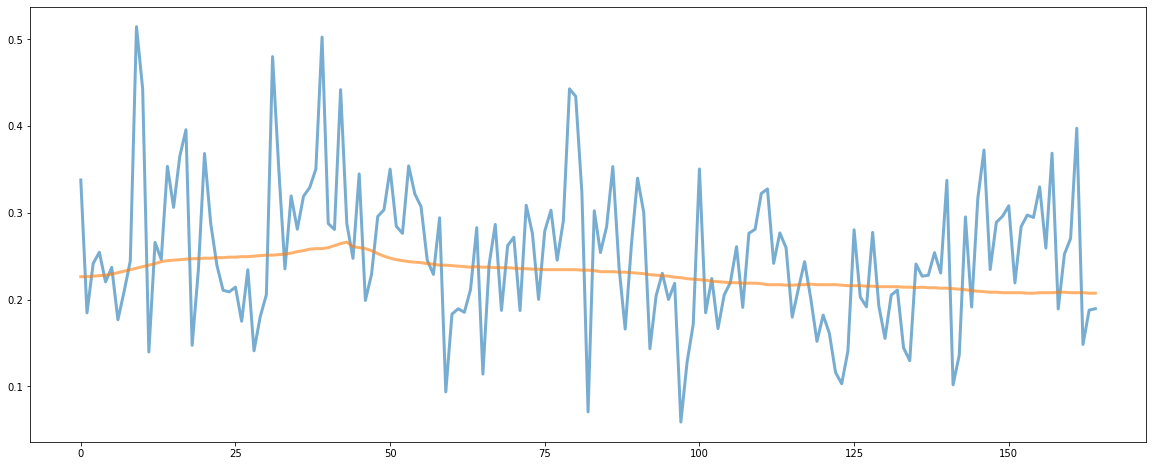

In [186]:
plt.figure(figsize =(20,8))

t = range(len(testing_data))
plt.plot(t,testing_data['Polarity Scores'].values,linewidth = 3,alpha=0.6)
plt.plot(t,best_predictions,linewidth = 3,alpha=0.6)

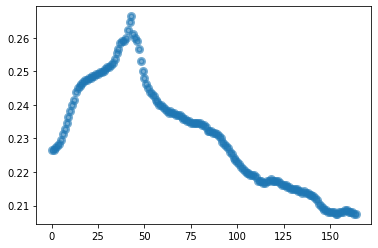

In [193]:
plt.scatter(t,best_predictions,linewidth = 3,alpha=0.6)

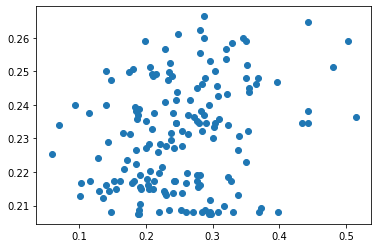

In [187]:
plt.scatter(testing_data['Polarity Scores'].values,best_predictions)

In [194]:
np.corrcoef(testing_data['Polarity Scores'].values,best_predictions)

array([[1.        , 0.25485889],
       [0.25485889, 1.        ]])

### Regression - VOX

### Comparing Regression Results (Do Tomorrow with Nhan)